In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

khadiza13_less_data_path = kagglehub.dataset_download('khadiza13/less-data')

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModel
import timm
import matplotlib.pyplot as plt

In [ ]:
csv_path = "/kaggle/input/less-data/changed_ds/new_ds_small.csv"
img_dir = "/kaggle/input/less-data/changed_ds/img"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
label2idx = {
    "stereotype & objectification": 0,
    "violence or abuse": 1,
    "non-misogynistic": 2
}
idx2label = {v: k for k, v in label2idx.items()}


Epoch 1


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.0124

Epoch 2


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 2.1837

Epoch 3


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.5123

Epoch 4


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.0297

Epoch 5


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.8596

Epoch 6


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.6723

Epoch 7


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5562

Epoch 8


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4262

Epoch 9


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.3373

Epoch 10


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.3229

Epoch 11


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.2089

Epoch 12


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.1849

Epoch 13


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.1338

Epoch 14


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.1083

Epoch 15


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.0760

Epoch 16


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.0712

Epoch 17


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.0657

Epoch 18


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.0723

Epoch 19


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.0731

Epoch 20


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.0509

Classification Report:
                              precision    recall  f1-score   support

stereotype & objectification       0.66      0.88      0.76       156
           violence or abuse       0.82      0.51      0.63        83
            non-misogynistic       0.89      0.78      0.84       162

                    accuracy                           0.77       401
                   macro avg       0.79      0.72      0.74       401
                weighted avg       0.79      0.77      0.76       401



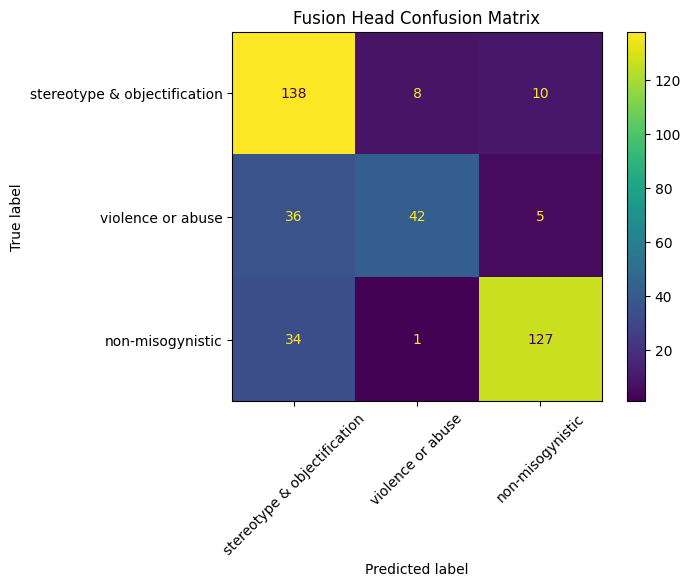

In [ ]:
from tqdm.notebook import tqdm, trange
# ======================= DATASET =========================
class MemeDataset(Dataset):
    def __init__(self, dataframe, img_dir, tokenizer, transform):
        self.data = dataframe
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.img_dir, row["image"])
        image = self.transform(Image.open(image_path).convert("RGB"))
        text = row["text"]
        label = label2idx[row["label"]]

        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
        return {
            "image": image,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label)
        }

# ======================= MODEL =========================
class MultiModalModel(nn.Module):
    def __init__(self, text_model_name="csebuetnlp/banglabert", image_model_name="efficientnet_b0", num_classes=3):
        super().__init__()

        # Text Encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, 256)

        # Image Encoder
        self.image_encoder = timm.create_model(image_model_name, pretrained=True, num_classes=0)
        self.image_proj = nn.Linear(self.image_encoder.num_features, 256)

        # Fusion Layer (global + local)
        self.fusion = nn.Sequential(
            nn.Linear(256 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Multi-task heads
        self.text_head = nn.Linear(256, num_classes)
        self.image_head = nn.Linear(256, num_classes)
        self.fusion_head = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image):
        # Text
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_global = text_outputs.last_hidden_state[:, 0]  # [CLS] token
        text_embed = self.text_proj(text_global)

        # Image
        image_global = self.image_encoder(image)
        image_embed = self.image_proj(image_global)

        # Fusion
        combined = torch.cat([text_embed, image_embed], dim=1)
        fused = self.fusion(combined)

        # Heads
        text_logits = self.text_head(text_embed)
        image_logits = self.image_head(image_embed)
        fusion_logits = self.fusion_head(fused)

        return text_logits, image_logits, fusion_logits

# ======================= TRAINING =========================
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        image = batch["image"].to(device)
        label = batch["label"].to(device)

        text_logits, image_logits, fusion_logits = model(input_ids, attention_mask, image)

        loss_text = criterion(text_logits, label)
        loss_image = criterion(image_logits, label)
        loss_fusion = criterion(fusion_logits, label)

        loss = loss_text + loss_image + loss_fusion
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            image = batch["image"].to(device)
            label = batch["label"].to(device)

            _, _, fusion_logits = model(input_ids, attention_mask, image)
            pred = torch.argmax(fusion_logits, dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return preds, labels

# ======================= PREP =========================
df = pd.read_csv(csv_path)
df = df.rename(columns={"Unnamed: 0": "image"})

tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = MemeDataset(df, img_dir, tokenizer, transform)

# Split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

# Model
model = MultiModalModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# ======================= TRAIN LOOP =========================
for epoch in range(20):
    print(f"\nEpoch {epoch+1}")
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f}")

# ======================= EVALUATE =========================
preds, labels = evaluate(model, test_loader)
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=label2idx.keys()))

# ======================= CONFUSION MATRIX =========================
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label2idx.keys())
disp.plot(xticks_rotation=45)
plt.title("Fusion Head Confusion Matrix")
plt.show()
